In [1]:
import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
#from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import precision_recall_fscore_support as score

In [2]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, precision_score, recall_score
from sklearn.metrics import plot_roc_curve

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [5]:
df = pd.read_csv('datasetforclassification.csv', engine='python',usecols=['Base_Reviews','My_Labels'])
df = df[pd.notnull(df['My_Labels'])]
print(df.head())
print(df['Base_Reviews'].astype(str).apply(lambda x: len(x.split(' '))).sum())
df.groupby('My_Labels').count()

  My_Labels                                       Base_Reviews
0   sadness  I am crying . Bought and paid the app.and don'...
1     anger  downloaded and deleted because I faces problem...
2   sadness  From some time the app shows invalid file when...
3   disgust  You can only make calls to users of this app.I...
4   disgust  I couldn't even sign up it just exited out and...
212825


,Base_Reviews
My_Labels,
anger,1562
disgust,785
fear,2729
sadness,1923


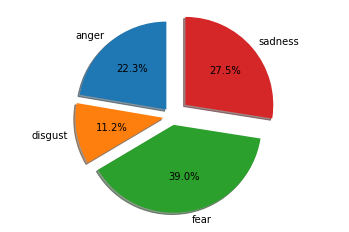

In [57]:
labels  = My_Labels = 'anger','disgust','fear','sadness'
sizes =[1562,785,2729,1924]
explode =(0.1,0.1,0.1,0.2) 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels =labels , autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## clean_text
clean the text by removing special characters, punctuations, etc.

In [7]:
# Text Pre-processing (text cleaning techniques)
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nekdil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def print_plot(index):
    example = df[df.index == index][['Base_Reviews', 'My_Labels']].values[0]
    if len(example) > 0:
        print(example[0])
        print('My_Labels:', example[1])
print_plot(1)

downloaded and deleted because I faces problem in the dificult  layout. And also I got problem like this " invalid file when trying to open". Can you please fix this. Bothering me bro
My_Labels: anger


In [9]:
# We want to show a look a Clean text and lables as you wanna.(After text_Preprocessing)
df['Base_Reviews'] = df['Base_Reviews'].astype(str).apply(clean_text)
print_plot(1) # 4567

downloaded deleted faces problem dificult layout also got problem like invalid file trying open please fix bothering bro
My_Labels: anger


In [10]:
def clean_text(text):
    """ clean the text by removing special characters, punctuations, etc. """
    text = text.lower()
    remove_xx_seq  = re.compile('xx+')
    replace_by_space = re.compile('[/(){}\[\]\|@,;]')
    remove_special_characters = re.compile('[^0-9a-z +]')
    remove_extra_space = re.compile('[^A-Za-z0-9]+')
    remove_numbers = re.compile('[0-9]+')
    text = re.sub(remove_xx_seq, ' ', text)
    text = re.sub(replace_by_space, ' ', text)
    text = re.sub(remove_special_characters, ' ', text)
    text = re.sub(remove_numbers, ' ', text)
    text = re.sub(remove_extra_space, ' ', text)
    return text.strip()

## preprocess_corpus
Preprocess the entire corpus including cleaning the text documents and return the updated dataframe.

In [11]:
def preprocess_corpus(df, column='text'):
    """ Preprocess the entire corpus including cleaning the text documents and return the updated dataframe. """
    df[column] = df[column].apply(clean_text)
    return df

## Encode_labels
Encode the class labels into a numbers.

In [12]:
def encode_labels(labels):
    """ Encode the class labels into a numbers. """
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    #label_encoder.get_vocabulary()
    return label_encoder


## Compute_tfidf
 Calculate the tfidf features for all the text documents and return a (documents, fatures) matrix. 

In [13]:
def compute_tfidf(corpus, stop_words='english', ngram_range=(1, 1), max_features=None):
    """ Calculate the tfidf features for all the text documents and return a (documents, fatures) matrix. """
    vectorizer = TfidfVectorizer(input='content', stop_words=stop_words, ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)
    print('Computing tfidf features...', end='')
    X = vectorizer.fit_transform(corpus)
    print('done!')
    return X, vectorizer

## Count Vectorizer

In [14]:
# def compute_count(corpus, stop_words='english', ngram_range=(1, 1), max_features=None):
#     """ Calculate the Count Vectorizer features for all the text documents and return a (documents, fatures) matrix. """
#     vectorizer = CountVectorizer(input='content', stop_words=stop_words, ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)
#     print('Computing tfidf features...', end='')
#     X = vectorizer.fit_transform(corpus)
#     print('done!')
#     return X, vectorizer

## Train_test_model
Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports.

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
alg_accuracy= []
alg_p_r_f_score =[]

def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    """ Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports. """
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    ####javed####
    alg_accuracy= accuracy_score(predictions, y_test)
    alg_p_r_f_score = precision_recall_fscore_support(y_test,predictions, average=None)
     ####javed####
    f1score = f1_score(y_test, predictions, average='weighted', pos_label=4)
    confusionMatrix = confusion_matrix(y_test, predictions)
    recall = recall_score(y_test, predictions, average='weighted', pos_label=4)
    precision = precision_score(y_test, predictions, average='weighted', pos_label=4)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
#    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, accuracy, precision, recall, f1score, alg_accuracy, alg_p_r_f_score
    #return  predictions, accuracy, tpr, fpr

Number of categories:  ['sadness' 'anger' 'disgust' 'fear']



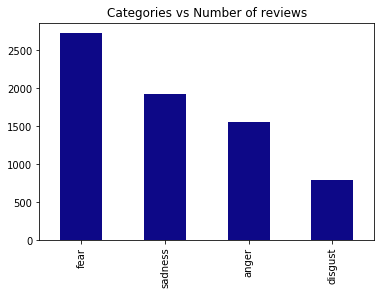

In [16]:
categories = df.My_Labels.unique()
print('Number of categories: ', categories)
print()
df.My_Labels.value_counts().plot(kind='bar', title='Categories vs Number of reviews', cmap='plasma')

# Setting for model TFIDF Features

In [17]:
# Create tfidf features from the text
stop_words    = 'english'
ngram_range   = (1, 1)
max_features  = None
X, vectorizer = compute_tfidf(df['Base_Reviews'].apply(lambda x: np.str_(x)), stop_words, ngram_range, max_features)
#X, vectorizer = compute_count(df['Base_Reviews'].apply(lambda x: np.str_(x)), stop_words, ngram_range, max_features)

# Encode the labels
labels = df.My_Labels.unique()
label_encoder = encode_labels(labels)
y = label_encoder.transform(df.My_Labels)
print(X)
print(vectorizer)
print(y)

Computing tfidf features...done!
  (0, 1062)	0.1384327216037618
  (0, 2609)	0.18087186210068545
  (0, 1365)	0.22098316373222532
  (0, 1653)	0.24487939556752852
  (0, 2774)	0.23612225096464062
  (0, 2044)	0.18932629536637202
  (0, 3656)	0.17263677394369037
  (0, 2440)	0.16245831283326997
  (0, 2354)	0.14878206843319527
  (0, 3548)	0.17300892440676294
  (0, 1338)	0.18629512502217763
  (0, 1796)	0.2050806995949849
  (0, 3067)	0.22370897448137317
  (0, 290)	0.17609890503929834
  (0, 3478)	0.11920490400349872
  (0, 12)	0.29205585427002606
  (0, 1607)	0.2059576375241476
  (0, 1879)	0.13374732675852646
  (0, 3821)	0.2168513020393545
  (0, 1069)	0.09951008525780773
  (0, 294)	0.3144770470793188
  (0, 2408)	0.21220915940755944
  (0, 507)	0.23329539348116746
  (0, 888)	0.2579610642189091
  (1, 522)	0.2648510970622822
  :	:
  (6995, 1448)	0.47801159657314796
  (6996, 1506)	0.3404622117689185
  (6996, 2567)	0.27068589749466687
  (6996, 2098)	0.31927074405140515
  (6996, 617)	0.2768437989681537
  (

## Import Oversampling and Under-sampling methods

In [18]:
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
sm = SMOTE()
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

In [19]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)

# Oversampling

### MultinomialNB

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 3.99s
mean accuracy: 0.78 %
mean f1 socre: 0.79 %
mean precision: 0.80 %
mean recall: 0.78 %
the average accuracy of MNB is 0.7846834253014511
the presion, recall, f are [[  0.75084086   0.65699681   0.88296023   0.77241014]
 [  0.79706435   0.89298929   0.73285795   0.80391839]
 [  0.77289799   0.75651627   0.80070713   0.78712293]
 [156.2         78.5        272.9        192.3       ]]
0.9295439027229078
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


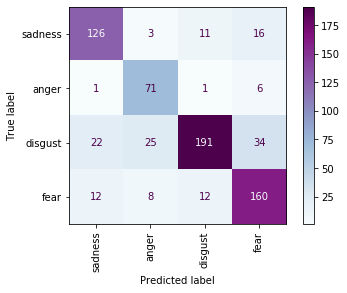

In [20]:
from scipy import interp
nb_model = MultinomialNB()

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []
#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###
roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
#n1 roc_auc_four = []

tprs_zero_nb = []
tprs_one_nb = []
tprs_two_nb = []
tprs_three_nb = []
#n1 tprs_four_nb = []

mean_fpr = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre,alg_accuracy, alg_p_r_f_score  = train_test_model(nb_model, X_train_res, X_test, y_train_res, y_test, labels)
    #print("the accuracy is",alg_accuracy)
    #break
   # fpr_zero, tpr_zero, _ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,3], pos_label=3)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=3)
    #fpr_four, tpr_four, _____ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=4)
    
    tprs_one_nb.append(interp(mean_fpr, fpr_one, tpr_one))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    #roc_auc_four = (auc(fpr_four, tpr_four))
    
    #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
      
en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four = sum(roc_auc_four) / len(roc_auc_four)
#print("\nROC across folds for four: ", roc_four)

mean_tpr = np.mean(tprs_one_nb, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of MNB is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr)
#print(mean_fpr)
print(mean_auc)
#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

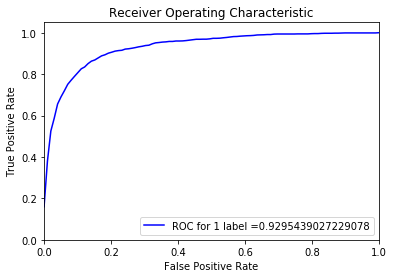

In [21]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(mean_fpr, mean_tpr, 'b', label= "ROC for 1 label =" +str(mean_auc))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### LogisticRegression

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 13.51s
mean accuracy: 0.85 %
mean f1 socre: 0.85 %
mean precision: 0.86 %
mean recall: 0.85 %

ROC across folds for zero:  0.4406422771288356

ROC across folds for one:  0.9852144718582052

ROC across folds for two:  0.44759937550051554

ROC across folds for three:  0.3717369617433552

ROC across folds for four:  nan
the average accuracy of LR is 0.851122215409769
the presion, recall, f are [[  0.87936772   0.92686786   0.81724888   0.86119064]
 [  0.77721705   0.77323921   0.92414754   0.83927299]
 [  0.82477945   0.84240971   0.86

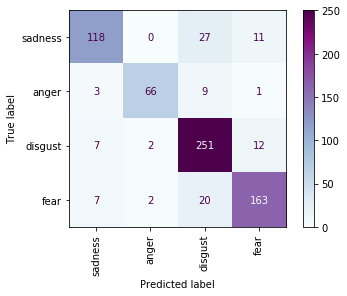

In [22]:
log_model = LogisticRegression(penalty='l2', max_iter=500)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(log_model, X_train, X_test, y_train, y_test, labels)
    
    fpr_zero, tpr_zero, _ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
     #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of LR is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####


#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(log_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

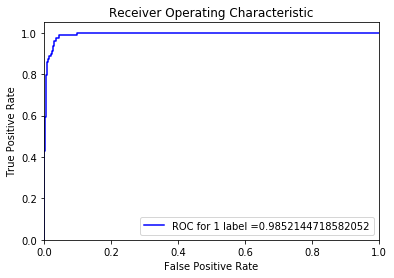

In [23]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### LinearSVC

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 1.66s
mean accuracy: 0.90 %
mean f1 socre: 0.90 %
mean precision: 0.90 %
mean recall: 0.90 %
the average accuracy of LSV is 0.9031203760474147
the presion, recall, f are [[  0.90317034   0.86394769   0.92962528   0.88618611]
 [  0.9109791    0.96049984   0.88345588   0.90113882]
 [  0.90691608   0.90955269   0.90587718   0.8933151 ]
 [156.2         78.5        272.9        192.3       ]]
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


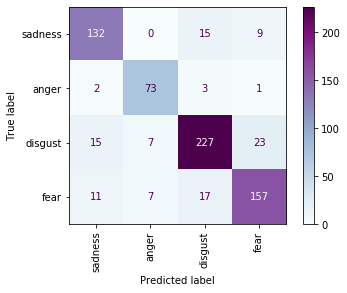

In [24]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_svm = []

tprs_zero_svm = []
tprs_one_svm = []
tprs_two_svm = []
tprs_three_svm = []
tprs_four_svm = []

mean_fpr_svm = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(svm, X_train_res, X_test, y_train_res, y_test, labels)
    
    #fpr_zero, tpr_zero, _ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=0)
    #fpr_one, tpr_one, __ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=3)
    fpr_four_svm, tpr_four_svm, _____ = roc_curve(y_test, svm.decision_function (X_test)[:,3], pos_label=3)

    tprs_four_svm.append(interp(mean_fpr_svm, fpr_four_svm, tpr_four_svm))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_svm, tpr_four_svm))
    
    
     #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four_svm = sum(roc_auc_four_svm) / len(roc_auc_four_svm)
#print("\nROC across folds for four: ", roc_four_svm)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of LSV is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

mean_tpr_svm = np.mean(tprs_four_svm, axis=0)
mean_auc_svm = auc(mean_fpr_svm, mean_tpr_svm)

#print(mean_tpr_svm)
#print(mean_fpr_svm)
#print(mean_auc_svm)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

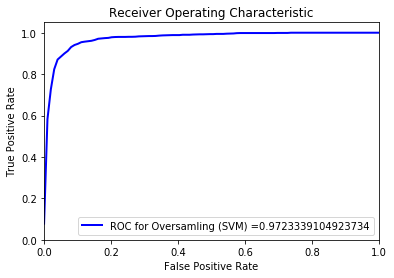

In [25]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_svm, mean_tpr_svm, 'b', label= "ROC for Oversamling (SVM) =" +str(mean_auc_svm),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### RandomForestClassifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 27.51s
mean accuracy: 0.97 %
mean f1 socre: 0.97 %
mean precision: 0.97 %
mean recall: 0.97 %
the average accuracy of RF is 0.974421418352749
the presion, recall, f are [[  0.97379084   0.98752969   0.96631907   0.98188667]
 [  0.97117834   0.99746835   0.9816769    0.95735373]
 [  0.97242609   0.99242063   0.97386852   0.9693369 ]
 [156.2         78.5        272.9        192.3       ]]
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


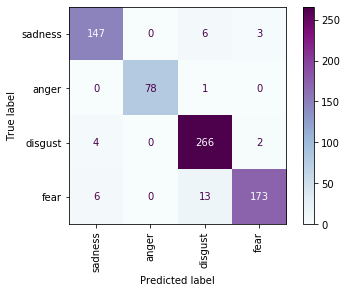

In [26]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_rf = []

tprs_zero_rf = []
tprs_one_rf = []
tprs_two_rf = []
tprs_three_rf = []
tprs_four_rf = []

mean_fpr_rf = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    #Oversampling
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(rf_model, X_train_res, X_test, y_train_res, y_test, labels)
    
    #fpr_zero, tpr_zero, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=0)
    #fpr_one, tpr_one, __ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four_rf, tpr_four_rf, _____ = roc_curve(y_test, rf_model.predict_proba (X_test)[:,3], pos_label=3)

    tprs_four_rf.append(interp(mean_fpr_rf, fpr_four_rf, tpr_four_rf))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_rf, tpr_four_rf))
    
        #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four_rf = sum(roc_auc_four_rf) / len(roc_auc_four_rf)
#print("\nROC across folds for four: ", roc_four_rf)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of RF is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####


mean_tpr_rf = np.mean(tprs_four_rf, axis=0)
mean_auc_rf = auc(mean_fpr_rf, mean_tpr_rf)

#print(mean_tpr_rf)
#print(mean_fpr_rf)
#print(mean_auc_rf)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

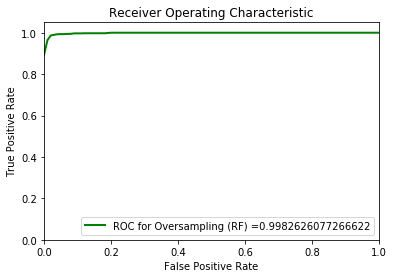

In [27]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_one, tpr_one, 'b', color='red', label= "Oversampling =" +str(roc_one))
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_rf, mean_tpr_rf, 'b', color='green', label= "ROC for Oversampling (RF) =" +str(mean_auc_rf),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### KNN

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 15.73s
mean accuracy: 0.88 %
mean f1 socre: 0.88 %
mean precision: 0.89 %
mean recall: 0.88 %

ROC across folds for zero:  0.42529351481828004

ROC across folds for one:  0.9918975619182261

ROC across folds for two:  0.41268267079845805

ROC across folds for three:  0.42341169510943893

ROC across folds for four:  nan
the average accuracy of KNN is 0.8838358880032698
the presion, recall, f are [[  0.93566331   0.95870191   0.8173597    0.94531813]
 [  0.81302874   0.83847777   0.95859459   0.85384283]
 [  0.8685599    0.89224367   

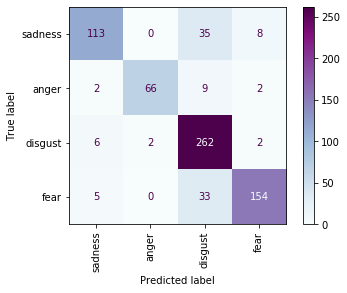

In [28]:
knn_model = KNeighborsClassifier(n_neighbors=3)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()

mean_fpr_rf = np.linspace(0,1,100)              # change the name of classifier

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(knn_model, X_train, X_test, y_train, y_test, labels)
    
    fpr_zero, tpr_zero, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, knn_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
            #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of KNN is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####


mean_tpr_rf = np.mean(tprs_four_rf, axis=0)
mean_auc_rf = auc(mean_fpr_rf, mean_tpr_rf)

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(knn_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

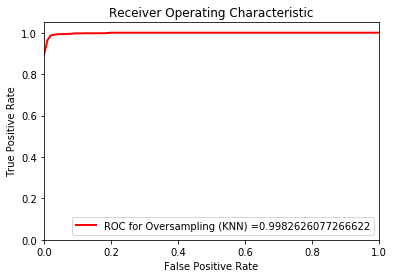

In [29]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.plot(mean_fpr_rf, mean_tpr_rf, 'b', color='red', label= "ROC for Oversampling (KNN) =" +str(mean_auc_rf),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Multilayer Perceptron

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 1978.23s
mean accuracy: 0.98 %
mean f1 socre: 0.98 %
mean precision: 0.98 %
mean recall: 0.98 %
the average accuracy of MLP is 0.9818520335172696
the presion, recall, f are [[  0.96460285   0.98632324   0.99295644   0.97930136]
 [  0.9903887    0.99358974   0.97325065   0.98231056]
 [  0.97729417   0.98984677   0.98297278   0.98069223]
 [156.2         78.5        272.9        192.3       ]]
0.9992678481399893
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


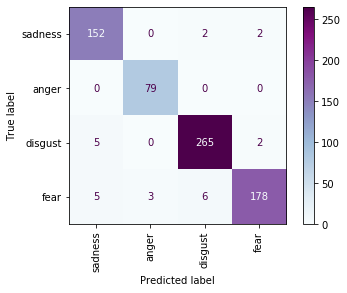

In [30]:
mlp_model = MLPClassifier(random_state=1, max_iter=300)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []

tprs_zero_mlp = []
tprs_one_mlp = []
tprs_two_mlp = []
tprs_three_mlp = []
tprs_four_mlp = []

mean_fpr_mlp = np.linspace(0,1,100)


st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(mlp_model, X_train_res, X_test, y_train_res, y_test, labels)
    
    #fpr_zero, tpr_zero, _ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=0)
    #fpr_one, tpr_one, __ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four_mlp, tpr_four_mlp, _____ = roc_curve(y_test, mlp_model.predict_proba (X_test)[:,3], pos_label=3)

    tprs_four_mlp.append(interp(mean_fpr_mlp, fpr_four_mlp, tpr_four_mlp))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_mlp, tpr_four_mlp))
    
        
            #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four = sum(roc_auc_four) / len(roc_auc_four)
#print("\nROC across folds for four: ", roc_four)
mean_tpr_mlp = np.mean(tprs_four_mlp, axis=0)
mean_auc_mlp = auc(mean_fpr_mlp, mean_tpr_mlp)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of MLP is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr_mlp)
#print(mean_fpr_mlp)
print(mean_auc_mlp)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(mlp_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

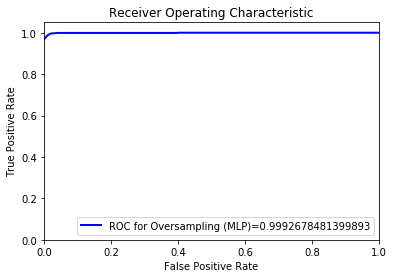

In [31]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_one, tpr_one, 'b', color='green', label= "Oversampling =" +str(roc_one))
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_mlp, mean_tpr_mlp, 'b', label= "ROC for Oversampling (MLP)=" +str(mean_auc_mlp),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gradient Boosting Classifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 56.53s
mean accuracy: 0.80 %
mean f1 socre: 0.80 %
mean precision: 0.81 %
mean recall: 0.80 %

ROC across folds for zero:  0.3368203853334311

ROC across folds for one:  0.9706442394760753

ROC across folds for two:  0.5361847765587949

ROC across folds for three:  0.3636136232624333

ROC across folds for four:  nan
the average accuracy of GB is 0.8008250562027387
the presion, recall, f are [[  0.84115477   0.86261471   0.75354556   0.83270604]
 [  0.71707088   0.82317429   0.87504983   0.7544986 ]
 [  0.77297207   0.84055118   0.80

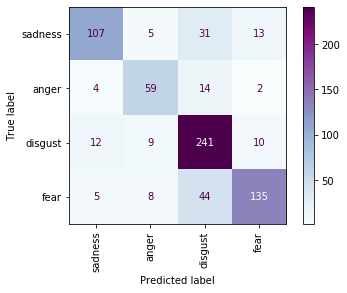

In [32]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    #X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, precision, recall, f1socre, alg_accuracy, alg_p_r_f_score = train_test_model(gb_model, X_train, X_test, y_train, y_test, labels)
    
    fpr_zero, tpr_zero, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, gb_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
                #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of GB is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(gb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

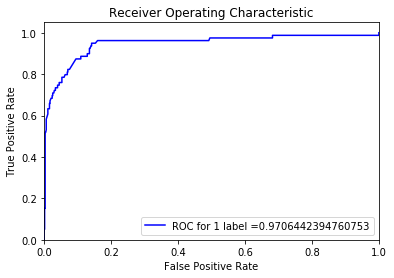

In [33]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Ensemble Methods
Ensemble methods are techniques that create multiple models and then combine them to produce improved results. 

### Voting Classifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 2847.57s
mean accuracy: 0.97 %
mean f1 socre: 0.97 %
mean precision: 0.97 %
mean recall: 0.97 %
the average accuracy of Voting is 0.9681375434293888
the presion, recall, f are [[  0.94765726   0.98745996   0.96782219   0.97848113]
 [  0.95648783   0.98594612   0.9772813    0.95734564]
 [  0.95192393   0.9865962    0.97247683   0.9676119 ]
 [156.2         78.5        272.9        192.3       ]]
[(0, 1406), (1, 706), (2, 2457), (3, 1731)]


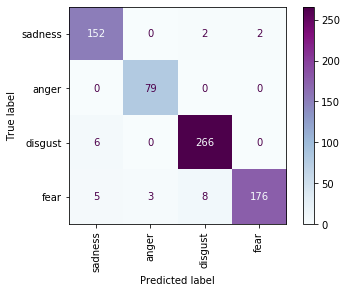

In [34]:
mlp_model = MLPClassifier(random_state=1, max_iter=300)

vote_model = VotingClassifier(estimators=[('mlp', mlp_model),('mlp1', mlp_model)], voting='soft')

accs = []
reports = []
f1 = []
pr = []
re =[]

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

#
roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []

tprs_zero_v = []
tprs_one_v = []
tprs_two_v = []
tprs_three_v = []
tprs_four_v = []

mean_fpr_v = np.linspace(0,1,100)
#
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    # X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(vote_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
    #reports.append(metrics_report)
    fpr_four_v, tpr_four_v, _____ = roc_curve(y_test, vote_model.predict_proba (X_test)[:,3], pos_label=3)     #
    tprs_four_v.append(interp(mean_fpr_v, fpr_four_v, tpr_four_v))                                             #
    roc_auc_four = (auc(fpr_four_v, tpr_four_v))                                                               #
    

    
                #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time)) 
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#
mean_tpr_v = np.mean(tprs_four_v, axis=0)
mean_auc_v = auc(mean_fpr_v, mean_tpr_v)
#
#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of Voting is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(vote_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

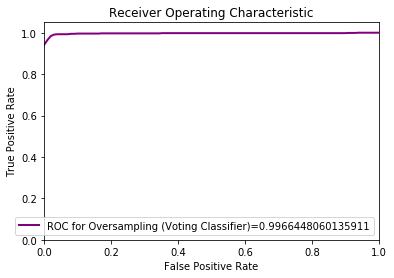

In [35]:
plt.title('Receiver Operating Characteristic')
plt.plot(mean_fpr_v, mean_tpr_v, 'b', color='purple', label= "ROC for Oversampling (Voting Classifier)=" +str(mean_auc_v),lw=2, alpha=1)
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### AdaBoost
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data.

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 96.49s
mean accuracy: 0.59 %
mean f1 socre: 0.61 %
mean precision: 0.59 %
mean recall: 0.59 %
the average accuracy of AdaBoost is 0.5927939914163091
the presion, recall, f are [[  0.5119922    0.89212384   0.6004225    0.57070345]
 [  0.59921607   0.77195716   0.52104476   0.61617822]
 [  0.5509638    0.82703422   0.55506465   0.58854912]
 [156.2         78.5        272.9        192.3       ]]
[(0, 1406), (1, 706), (2, 2457), (3, 1731)]


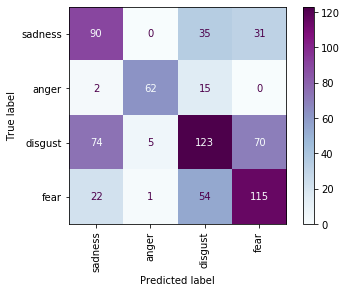

In [36]:
ada_model = AdaBoostClassifier(n_estimators=500)

accs = []
reports = []
f1 = []
pr = []
re =[]

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Oversample
    # X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(ada_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
    #reports.append(metrics_report)
    
        
                #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time)) 
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of AdaBoost is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

unique, counts = np.unique(y_train, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(ada_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

# Undersampling

### MultinomialNB

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 0.64s
mean accuracy: 0.68 %
mean f1 socre: 0.71 %
mean precision: 0.68 %
mean recall: 0.68 %

ROC across folds for zero:  0.354395958866786

ROC across folds for one:  0.9675505828932719

ROC across folds for two:  0.5065012937709763

ROC across folds for three:  0.3852839488234626

ROC across folds for four:  nan
the average accuracy of NBM is 0.6778132025342326
the presion, recall, f are [[  0.65562703   0.51064964   0.81310451   0.68454738]
 [  0.71510697   0.89811749   0.572009     0.70769376]
 [  0.68374184   0.650447     0.670

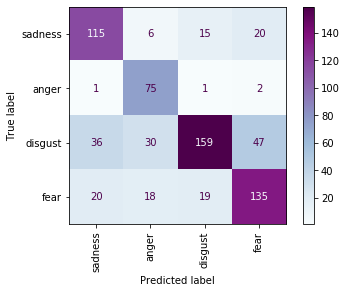

In [37]:
nb_model = MultinomialNB()

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(nb_model, X_train_under, X_test, y_train_under, y_test, labels)

    fpr_zero, tpr_zero, _ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, nb_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, nb_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
                 #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of NBM is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

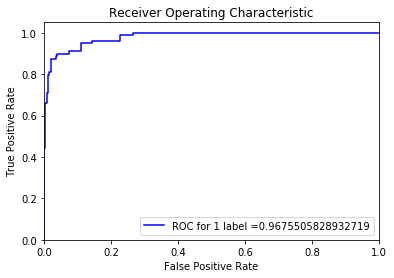

In [38]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### LogisticRegression

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 6.60s
mean accuracy: 0.75 %
mean f1 socre: 0.75 %
mean precision: 0.75 %
mean recall: 0.75 %

ROC across folds for zero:  0.39126993362481266

ROC across folds for one:  0.9812647270166414

ROC across folds for two:  0.49898232464486425

ROC across folds for three:  0.3553302660075874

ROC across folds for four:  nan
the average accuracy of LR is 0.7461056611485797
the presion, recall, f are [[  0.71603912   0.7051487    0.7774325    0.75466604]
 [  0.74133595   0.91084064   0.72187971   0.71704987]
 [  0.72803584   0.79438371   0.7

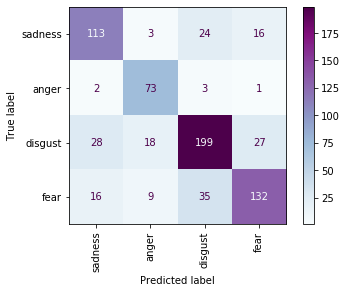

In [39]:
log_model = LogisticRegression(penalty='l2', max_iter=500)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(log_model, X_train_under, X_test, y_train_under, y_test, labels)

    fpr_zero, tpr_zero, _ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, log_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, log_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
                     #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####


    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of LR is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(log_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

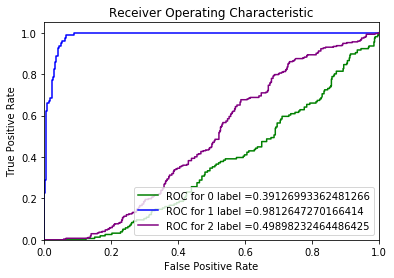

In [40]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### LinearSVC

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 0.74s
mean accuracy: 0.73 %
mean f1 socre: 0.74 %
mean precision: 0.73 %
mean recall: 0.73 %
the average accuracy of SVC is 0.7325336194563662
the presion, recall, f are [[  0.71653122   0.65110852   0.78223674   0.7319989 ]
 [  0.72598399   0.90702694   0.6944018    0.72067951]
 [  0.72098171   0.7575501    0.73537753   0.72553563]
 [156.2         78.5        272.9        192.3       ]]
0.8923403786132025
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


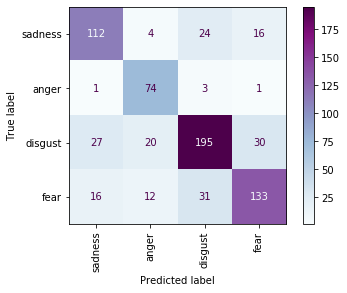

In [41]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_svm = []

tprs_zero_svm_under = []
tprs_one_svm_under = []
tprs_two_svm_under = []
tprs_three_svm_under = []
tprs_four_svm_under = []

mean_fpr_svm_under = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(svm, X_train_under, X_test, y_train_under, y_test, labels)

    #fpr_zero, tpr_zero, _ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=0)
    #fpr_one, tpr_one, __ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, svm.decision_function(X_test)[:,1], pos_label=3)
    fpr_four_under_svm, tpr_four_under_svm, _____ = roc_curve(y_test, svm.decision_function (X_test)[:,3], pos_label=3)

    tprs_four_svm_under.append(interp(mean_fpr_svm_under, fpr_four_under_svm, tpr_four_under_svm))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_under_svm, tpr_four_under_svm))
    
                         #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####


    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one = sum(roc_auc_one) / len(roc_auc_one)
#print("\nROC across folds for one: ", roc_one)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four_under_svm = sum(roc_auc_four_svm) / len(roc_auc_four_svm)
#print("\nROC across folds for four: ", roc_four_under_svm)

mean_tpr_svm_under = np.mean(tprs_four_svm_under, axis=0)
mean_auc_svm_under = auc(mean_fpr_svm_under, mean_tpr_svm_under)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of SVC is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr_svm_under)
#print(mean_fpr_svm_under)
print(mean_auc_svm_under)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

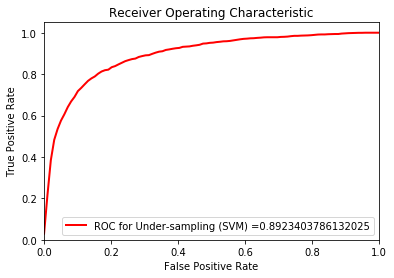

In [42]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_svm_under, mean_tpr_svm_under, 'b', color='red', label= "ROC for Under-sampling (SVM) =" +str(mean_auc_svm_under) ,lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### RandomForestClassifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 22.09s
mean accuracy: 0.80 %
mean f1 socre: 0.80 %
mean precision: 0.80 %
mean recall: 0.80 %
the average accuracy of RF is 0.7985411812793787
the presion, recall, f are [[  0.81371913   0.75192127   0.79956071   0.8134301 ]
 [  0.75864772   0.98347939   0.78270847   0.7779226 ]
 [  0.78467093   0.85189665   0.79073601   0.79486072]
 [156.2         78.5        272.9        192.3       ]]
0.934850691294542
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


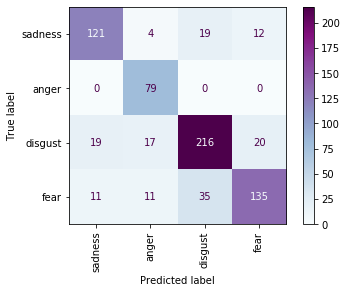

In [43]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_under = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_under = []

tprs_zero_rf_under = []
tprs_one_rf_under = []
tprs_two_rf_under = []
tprs_three_rf_under = []
tprs_four_rf_under = []

mean_fpr_rf_under = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(rf_model, X_train_under, X_test, y_train_under, y_test, labels)

    #fpr_zero, tpr_zero, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=0)
    #fpr_under, tpr_under, __ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four_under_rf, tpr_four_under_rf, _____ = roc_curve(y_test, rf_model.predict_proba (X_test)[:,3], pos_label=3)

    tprs_four_rf_under.append(interp(mean_fpr_rf_under, fpr_four_under_rf, tpr_four_under_rf))
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    roc_auc_four = (auc(fpr_four_rf, tpr_four_rf))
    
                             #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_one_under = sum(roc_auc_under) / len(roc_auc_under)
#print("\nROC across folds for one: ", roc_one_under)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_four_under_rf = sum(roc_auc_four_under) / len(roc_auc_four_under)
#print("\nROC across folds for four: ", roc_four_under_rf)

mean_tpr_rf_under = np.mean(tprs_four_rf_under, axis=0)
mean_auc_rf_under = auc(mean_fpr_rf_under, mean_tpr_rf_under)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of RF is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr_rf_under)
#print(mean_fpr_rf_under)
print(mean_auc_rf_under)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

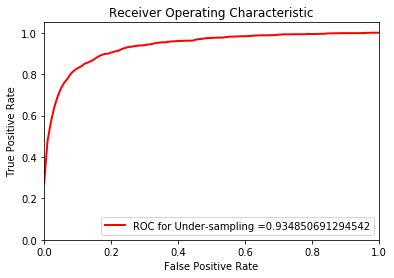

In [44]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_under, tpr_under, 'b', label= "Under-sampling =" +str(roc_one_under))
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_rf_under, mean_tpr_rf_under, 'b', color='red', label= "ROC for Under-sampling =" +str(mean_auc_rf_under),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### KNN

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 12.65s
mean accuracy: 0.66 %
mean f1 socre: 0.72 %
mean precision: 0.66 %
mean recall: 0.65 %

ROC across folds for zero:  0.41944214123824625

ROC across folds for one:  0.9816345003981286

ROC across folds for two:  0.4226790779363448

ROC across folds for three:  0.42170178339872955

ROC across folds for four:  nan
the average accuracy of KNN is 0.661666257919477
the presion, recall, f are [[  0.7807686    0.75032293   0.65987601   0.74842249]
 [  0.55702678   0.89044142   0.75555107   0.52010741]
 [  0.62338736   0.80315427   0.

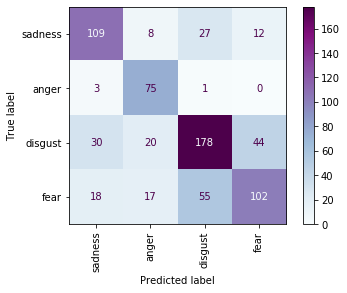

In [45]:
knn_model = KNeighborsClassifier(n_neighbors=3)
accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###
roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    X_train_under, y_train_under = rus.fit_resample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(knn_model, X_train_under, X_test, y_train_under, y_test, labels)

    fpr_zero, tpr_zero, _ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, knn_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, knn_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
    #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of KNN is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(knn_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

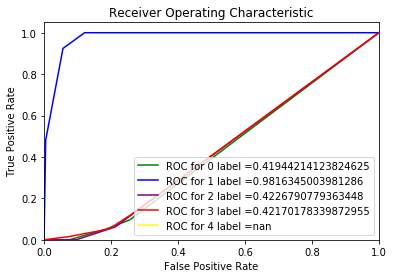

In [46]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### MLPClassifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 922.26s
mean accuracy: 0.84 %
mean f1 socre: 0.84 %
mean precision: 0.84 %
mean recall: 0.84 %
the average accuracy of MLP is 0.8396828121806662
the presion, recall, f are [[  0.80194456   0.83101137   0.86317967   0.84726363]
 [  0.85018782   1.           0.79954212   0.82264141]
 [  0.82517953   0.90736888   0.83000254   0.83456854]
 [156.2         78.5        272.9        192.3       ]]
0.9544776972261827
[(0, 2457), (1, 2457), (2, 2457), (3, 2457)]


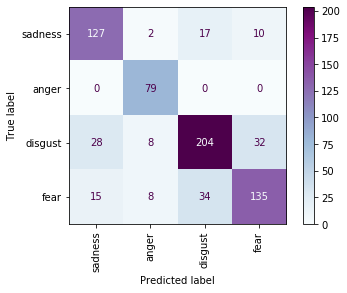

In [47]:
mlp_model = MLPClassifier(random_state=1, max_iter=300)
accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###
roc_auc_ = []
roc_auc_one_under = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four_mlp = []

tprs_zero_mlp_under = []
tprs_one_mlp_under = []
tprs_two_mlp_under = []
tprs_three_mlp_under = []
tprs_four_mlp_under = []

mean_fpr_mlp_under = np.linspace(0,1,100)

st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    #X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(mlp_model, X_train_under, X_test, y_train_under, y_test, labels)

    #fpr_zero, tpr_zero, _ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=0)
    #fpr_one_under, tpr_one_under, __ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=1)
    #fpr_two, tpr_two, ___ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=2)
    #fpr_three, tpr_three, ____ = roc_curve(y_test, mlp_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four_mlp_under, tpr_four_mlp_under, _____ = roc_curve(y_test, mlp_model.predict_proba (X_test)[:,3], pos_label=3)

    tprs_four_mlp_under.append(interp(mean_fpr_mlp_under, fpr_four_mlp_under, tpr_four_mlp_under))
    
        #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####
    
    #roc_auc_one = (auc(fpr_zero, tpr_zero))
    #roc_auc_one = (auc(fpr_one, tpr_one))
    #roc_auc_two = (auc(fpr_two, tpr_two))
    #roc_auc_three = (auc(fpr_three, tpr_three))
    #roc_auc_four = (auc(fpr_four_mlp_under, tpr_four_mlp_under))

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#roc_zero = sum(roc_auc_) / len(roc_auc_)
#print("\nROC across folds for zero: ", roc_zero)

#roc_mlp_under = sum(roc_auc_one_under) / len(roc_auc_one_under)
#print("\nROC across folds for one: ", roc_mlp_under)

#roc_two = sum(roc_auc_two) / len(roc_auc_two)
#print("\nROC across folds for two: ", roc_two)

#roc_three = sum(roc_auc_three) / len(roc_auc_three)
#print("\nROC across folds for three: ", roc_three)

#roc_mlp_under_four = sum(roc_auc_four_mlp) / len(roc_auc_four_mlp)
#print("\nROC across folds for four: ", roc_mlp_under_four)

mean_tpr_mlp_under = np.mean(tprs_four_mlp_under, axis=0)
mean_auc_mlp_under = auc(mean_fpr_mlp_under, mean_tpr_mlp_under)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of MLP is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(mean_tpr_mlp_under)
#print(mean_fpr_mlp_under)
print(mean_auc_mlp_under)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(mlp_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

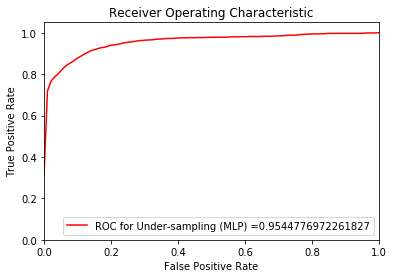

In [48]:
plt.title('Receiver Operating Characteristic')
#plt.plot(fpr_one_under, tpr_one_under, 'b', label= "Under-sampling =" +str(roc_mlp_under))
#plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
#plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
#plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
plt.plot(mean_fpr_mlp_under, mean_tpr_mlp_under, 'b', color='red', label= "ROC for Under-sampling (MLP) =" +str(mean_auc_mlp_under))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gradient Boosting Classifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 69.59s
mean accuracy: 0.80 %
mean f1 socre: 0.81 %
mean precision: 0.80 %
mean recall: 0.80 %

ROC across folds for zero:  0.3486772247576109

ROC across folds for one:  0.9927036263821399

ROC across folds for two:  0.5299698315644038

ROC across folds for three:  0.34967585678681556

ROC across folds for four:  nan
the average accuracy of GBC is 0.8049642346208868
the presion, recall, f are [[  0.81799332   0.76152186   0.80800643   0.81741031]
 [  0.78620774   0.99488802   0.77608678   0.78361399]
 [  0.80131706   0.86241377   0.

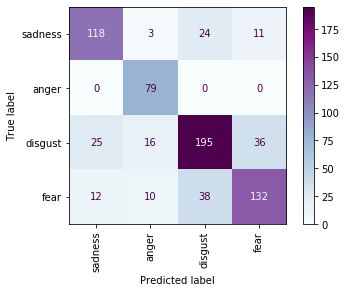

In [49]:
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

accs = []
reports = []
f1 = []
pr = []
re = []
pe = []

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

roc_auc_ = []
roc_auc_one = []
roc_auc_two = []
roc_auc_three = []
roc_auc_four = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    #X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(gb_model, X_train_under, X_test, y_train_under, y_test, labels)

    fpr_zero, tpr_zero, _ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=0)
    fpr_one, tpr_one, __ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=1)
    fpr_two, tpr_two, ___ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=2)
    fpr_three, tpr_three, ____ = roc_curve(y_test, gb_model.predict_proba(X_test)[:,1], pos_label=3)
    fpr_four, tpr_four, _____ = roc_curve(y_test, gb_model.predict_proba (X_test)[:,1], pos_label=4)

    roc_auc_.append(auc(fpr_zero, tpr_zero))
    roc_auc_one.append(auc(fpr_one, tpr_one))
    roc_auc_two.append(auc(fpr_two, tpr_two))
    roc_auc_three.append(auc(fpr_three, tpr_three))
    roc_auc_four.append(auc(fpr_four, tpr_four))
    
            #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####

    pe.append(predictions)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)


en_time = time.time()
#print('mean predictions: {:.2f} %'.format(sum(pe) / len(pe) ))
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

roc_zero = sum(roc_auc_) / len(roc_auc_)
print("\nROC across folds for zero: ", roc_zero)

roc_one = sum(roc_auc_one) / len(roc_auc_one)
print("\nROC across folds for one: ", roc_one)

roc_two = sum(roc_auc_two) / len(roc_auc_two)
print("\nROC across folds for two: ", roc_two)

roc_three = sum(roc_auc_three) / len(roc_auc_three)
print("\nROC across folds for three: ", roc_three)

roc_four = sum(roc_auc_four) / len(roc_auc_four)
print("\nROC across folds for four: ", roc_four)

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of GBC is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####

#print(fpr_zero)
#print(tpr_zero)

#print(metrics_report)
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(gb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

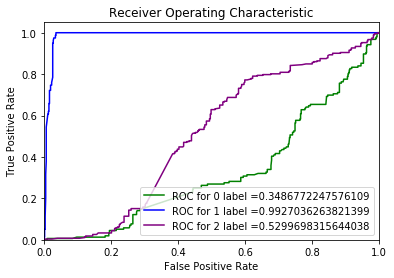

In [50]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_zero, tpr_zero, 'b', color='green', label= "ROC for 0 label =" +str(roc_zero))
plt.plot(fpr_one, tpr_one, 'b', label= "ROC for 1 label =" +str(roc_one))
plt.plot(fpr_two, tpr_two, 'b', color='purple',  label= "ROC for 2 label =" +str(roc_two))
#plt.plot(fpr_three, tpr_three, 'b', color='red',  label= "ROC for 3 label =" +str(roc_three))
#plt.plot(fpr_four, tpr_four, 'b', color='yellow', label= "ROC for 4 label =" +str(roc_four))
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Ensemble Methods
Ensemble methods are techniques that create multiple models and then combine them to produce improved results.

### Voting Classifier

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 26.41s
mean accuracy: 0.80 %
mean f1 socre: 0.80 %
mean precision: 0.80 %
mean recall: 0.80 %
the average accuracy of Voting Classifier is 0.7983923973022685
the presion, recall, f are [[  0.75542504   0.71953792   0.84082873   0.82810583]
 [  0.8079087    0.96179812   0.75411011   0.7867282 ]
 [  0.7805307    0.82282504   0.79490108   0.80654301]
 [156.2         78.5        272.9        192.3       ]]
[(0, 706), (1, 706), (2, 706), (3, 706)]


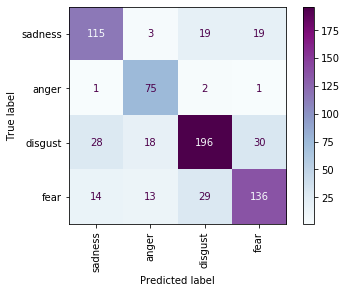

In [51]:
nb_model = MultinomialNB()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
log_model = LogisticRegression(penalty='l2', max_iter=500)

vote_model = VotingClassifier(estimators=[('nb', nb_model), ('rf', rf_model), ('log', log_model)], voting='hard')

accs = []
reports = []
f1 = []
pr = []
re =[]
#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###

st_time = time.time()

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    #X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(vote_model, X_train_under, X_test, y_train_under, y_test, labels)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
    #reports.append(metrics_report)
    
                #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####
    
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))


#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of Voting Classifier is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####


unique, counts = np.unique(y_train_under, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(vote_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

### Ada Boost Classifier
The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data.

Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Start training...done!
Start testing...done!
Total time: 109.99s
mean accuracy: 0.62 %
mean f1 socre: 0.62 %
mean precision: 0.62 %
mean recall: 0.62 %
the average accuracy of AdaBoost is 0.6170839975475169
the presion, recall, f are [[  0.54528211   0.83104764   0.61590156   0.59181315]
 [  0.54735424   0.85714054   0.56979369   0.64270833]
 [  0.54566005   0.84335217   0.59154477   0.61572801]
 [156.2         78.5        272.9        192.3       ]]
[(0, 706), (1, 706), (2, 706), (3, 706)]


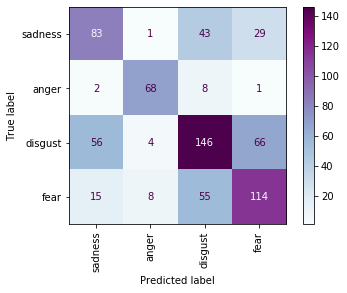

In [52]:
ada_model = AdaBoostClassifier(n_estimators=500)

accs = []
reports = []
f1 = []
pr = []
re =[]

#javed#
accuracy_ = []
P_r_f = []

mean_accuracy= []
mean_p_r_f =[]
##javed###
st_time = time.time()

for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # Undersampling
    #X_train_under, y_train_under = rus.fit_sample(X_train, y_train)
    predictions, accuracy, f1socre, precision, recall, alg_accuracy, alg_p_r_f_score = train_test_model(ada_model, X_train_under, X_test, y_train_under, y_test, labels)
    accs.append(accuracy)
    f1.append(f1socre)
    pr.append(precision)
    re.append(recall)
    #reports.append(metrics_report)
    
    #javed###      
    accuracy_.append(alg_accuracy)
    P_r_f.append(alg_p_r_f_score)
    #### jave ####
    
    
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f} %'.format(np.mean(accs)))
print('mean f1 socre: {:.2f} %'.format(np.mean(f1)))
print('mean precision: {:.2f} %'.format(np.mean(pr)))
print('mean recall: {:.2f} %'.format(np.mean(re)))

#### jave ####
mean_accuracy= np.mean(accuracy_, axis=0)
print("the average accuracy of AdaBoost is",mean_accuracy)
    
mean_p_r_f=np.mean(P_r_f, axis=0)
print("the presion, recall, f are", mean_p_r_f)
#### jave ####
unique, counts = np.unique(y_train_under, return_counts=True)
print(list(zip(unique, counts)))
plot_confusion_matrix(ada_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

# ROC Combine

### ROC for Random Forest

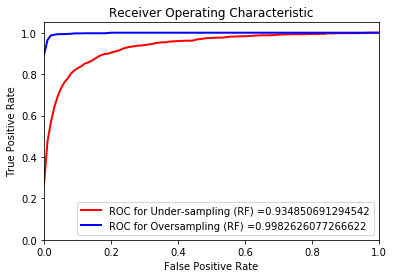

In [53]:
plt.title('Receiver Operating Characteristic')
plt.plot(mean_fpr_rf_under, mean_tpr_rf_under, 'b', color='red', label= "ROC for Under-sampling (RF) =" +str(mean_auc_rf_under),lw=2, alpha=1)
plt.plot(mean_fpr_rf, mean_tpr_rf, 'b', label= "ROC for Oversampling (RF) =" +str(mean_auc_rf),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### ROC for MLP

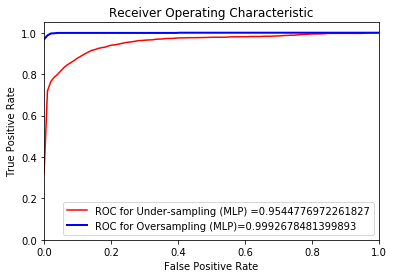

In [54]:
plt.title('Receiver Operating Characteristic')
plt.plot(mean_fpr_mlp_under, mean_tpr_mlp_under, 'b', color='red', label= "ROC for Under-sampling (MLP) =" +str(mean_auc_mlp_under))
plt.plot(mean_fpr_mlp, mean_tpr_mlp, 'b', label= "ROC for Oversampling (MLP)=" +str(mean_auc_mlp),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### ROC for SVM

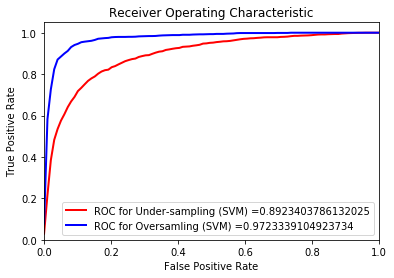

In [55]:
plt.title('Receiver Operating Characteristic')
plt.plot(mean_fpr_svm_under, mean_tpr_svm_under, 'b', color='red', label= "ROC for Under-sampling (SVM) =" +str(mean_auc_svm_under) ,lw=2, alpha=1)
plt.plot(mean_fpr_svm, mean_tpr_svm, 'b', label= "ROC for Oversamling (SVM) =" +str(mean_auc_svm),lw=2, alpha=1)
plt.legend(loc = 'lower right')
#plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()